In [8]:
from sklearn.decomposition import PCA
from Data.load import load
import numpy as np

In [25]:
train = load(take=20, train_test_split=1)
train.shape

Loading images: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


(20, 80, 96, 80)

In [167]:
def wnd_from(train,stride=3,wndlen=8):
    windows = []
    for i in range(0,train.shape[1]-wndlen,stride):
        for j in range(0,train.shape[2]-wndlen,stride):
            for k in range(0,train.shape[3]-wndlen,stride):
                for img_idx in range(len(train)):
                    wnd = train[img_idx, i:i+wndlen, j:j+wndlen, k:k+wndlen]
                    windows.append(wnd)

    return np.stack([w.flatten() for w in windows])

wndlen = 8
windows = wnd_from(train,wndlen=wndlen)
windows.shape

(345600, 512)

In [168]:
pca = PCA(20)
windows1 = pca.fit_transform(np.stack([w.flatten() for w in windows]))
np.sum(pca.explained_variance_ratio_)

0.9511525764582741

In [169]:
# Display the image and see if information is retained
def apply_pca(pca, img):
    img_pca = []
    r=wndlen//2
    for i in range(0,train.shape[1]-r,r):
        img_1 = []
        for j in range(0,train.shape[2]-r,r):
            img_2 = []
            for k in range(0,train.shape[3]-r,r):
                wnd = img[i:i+wndlen, j:j+wndlen, k:k+wndlen].flatten()
                img_2.append(pca.transform(wnd.reshape(1,-1))[0])
            img_1.append(img_2)
        img_pca.append(img_1)
    img_pca = np.array(img_pca)
    return img_pca

img_pca = apply_pca(pca, train[0])
img_pca.shape # 26 730

(19, 23, 19, 20)

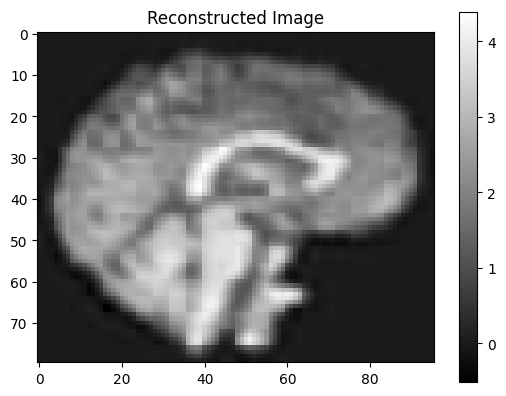

In [170]:
def reconstruct_img(img_pca, pca, output_shape):
    reconstructed_img = np.zeros(output_shape)
    r=wndlen//2
    for i in range(img_pca.shape[0]):
        for j in range(img_pca.shape[1]):
            for k in range(img_pca.shape[2]):
                wnd_reconstructed = pca.inverse_transform(img_pca[i,j,k]).reshape(wndlen, wndlen, wndlen)  # Reconstruct
                reconstructed_img[i*r:i*r+wndlen, j*r:j*r+wndlen, k*r:k*r+wndlen] += wnd_reconstructed  # Place it back
    return reconstructed_img

reconstructed_img = reconstruct_img(img_pca,pca,train[0].shape)
# Display the reconstructed image
import matplotlib.pyplot as plt

plt.imshow(np.rot90(reconstructed_img[train.shape[1]//2,:, :]), cmap='gray')  # Display middle slice
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

In [171]:
wndlen = 8
windows = wnd_from(np.array([img_pca]),wndlen=wndlen)
windows.shape

(80, 10240)

In [172]:
pca1 = PCA(60)
windows1 = pca1.fit_transform(np.stack([w.flatten() for w in windows]))
np.sum(pca1.explained_variance_ratio_)

0.970553888172652

In [ ]:
img_pca1 = apply_pca(pca1, img_pca)
reconstructed_img1 = reconstruct_img(img_pca,pca1,img_pca.shape)

ValueError: X has 8960 features, but PCA is expecting 10240 features as input.

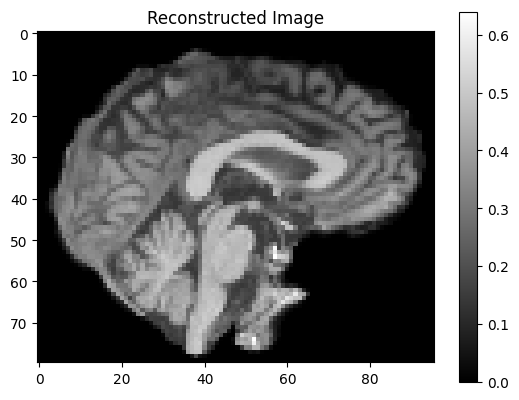

In [128]:
plt.imshow(np.rot90(train[0,train.shape[1]//2,:, :]), cmap='gray')  # Display middle slice
plt.title("Reconstructed Image")
plt.colorbar()
plt.show()

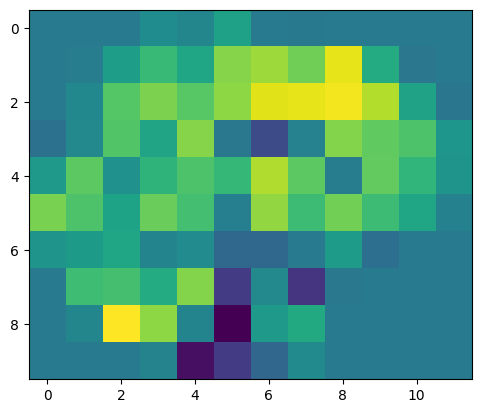

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(np.rot90(img_pca[5,:,:,2]))

In [ ]:
train.shape[1:] # 614 400

(80, 96, 80)

In [ ]:
train_pca = []

for img_idx in range(len(train)):
    for i in range(0,train.shape[1]-wndlen,stride):
        for j in range(0,train.shape[2]-wndlen,stride):
            for k in range(0,train.shape[3]-wndlen,stride):
                wnd = train[img_idx, i:i+wndlen, j:j+wndlen, k:k+wndlen]
                windows.append(wnd)


(387500, 30)

In [88]:
from tensorflow.keras import layers, Model, activations

input_shape = list(windows.shape[1:])+[1]
# Encoder
encoder_input = x = layers.Input(shape=input_shape)
x = layers.Conv3D(4, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3D(10, (3, 3, 3), strides=2, activation=activations.leaky_relu, padding="same")(x)
pre_flatten_shape = x.shape
print(f"Pre-flattened latent shape: {pre_flatten_shape}")
x = layers.Flatten()(x)
encoded = layers.Dense(20, activation="relu")(x)
encoder = Model(encoder_input, encoded, name="encoder")

# Decoder
decoder_input = x = layers.Input(shape=encoded.shape[1:])  # Adjusted latent space shape

# Reshape back to 3D
x = layers.Dense(
    pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4],
    activation="relu"
)(decoder_input)
x = layers.Reshape(pre_flatten_shape[1:])(x)
x = layers.Conv3DTranspose(10, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
x = layers.Conv3DTranspose(4, (3, 3, 3),2, activation=activations.leaky_relu, padding="same")(x)
decoded = layers.Conv3D(1, (3, 3, 3), activation="sigmoid", padding="same")(x)
decoder = Model(decoder_input, decoded, name="decoder")

# Full Autoencoder (combine encoder and decoder)
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

# Compile the autoencoder
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

autoencoder.fit(windows,windows,epochs=5,verbose=True,batch_size=64)

Pre-flattened latent shape: (None, 2, 2, 2, 10)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 8, 8, 8, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 20)             │         2,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 8, 8, 8, 1)     │         5,583 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,405 (32.83 KB)

 Trainable params: 8,405 (32.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0109
Epoch 2/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0022
Epoch 3/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 4/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0019
Epoch 5/5
5400/5400 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0018


In [92]:
import numpy as np

# Get autoencoder output (reconstructed data)
x_reconstructed = autoencoder.predict(windows)

# Compute total variance of original data
total_variance = np.var(windows)

# Compute reconstruction variance (MSE between x and x_reconstructed)
reconstruction_variance = np.mean((windows - x_reconstructed.reshape(345600,8,8,8)) ** 2)

# Compute retained variance
retained_variance = 1 - (reconstruction_variance / total_variance)

print(f"Retained Variance: {retained_variance:.4f}")


10800/10800 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
Retained Variance: 0.9509
